In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import numpy as np
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
#import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")
from parrot import py_predictor

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


# predictor outputs

In [3]:
pred_output = pd.read_csv("../output/tiled_TFs_with_both_parrot_pred.csv", index_col=0)
for predictor in ["padd_pred", "erij_pred"]:
    pred_output[predictor]= pred_output[predictor].str.replace("[", "")
    pred_output[predictor]= pred_output[predictor].str.replace("]", "")
pred_output["erij_pred"] = pred_output["erij_pred"].str.split(r'\s+')
pred_output["padd_pred"] = pred_output["padd_pred"].astype(float)
pred_output

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,padd_pred,erij_pred
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,39,0,1,0,2,6,1,1,1,3,5,-6,1.966898,"[0.9751895, 0.02481044]"
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,40,0,1,0,1,6,1,1,1,3,5,-6,1.697406,"[0.9843204, 0.01567965]"
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIR,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,41,0,1,0,1,6,1,1,2,3,4,-4,1.188476,"[0.9830169, 0.01698314]"
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRD,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,42,0,1,0,1,6,1,1,2,4,4,-5,1.641205,"[0.98094946, 0.01905053]"
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,43,0,1,0,2,6,1,1,2,4,3,-4,1.895335,"[0.97274613, 0.0272539, ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888576,LLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1630,1669,0,1,1,1,5,2,5,8,2,2,9,-0.070133,"[0.98760617, 0.01239386]"
888577,LTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1631,1670,0,1,1,1,4,2,5,8,2,2,9,-0.047968,"[0.99040896, 0.00959106]"
888578,TKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1632,1671,0,1,1,1,3,3,5,8,2,2,9,0.057944,"[0.99212974, 0.00787027]"
888579,KKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1633,1672,0,1,1,1,3,3,5,8,2,2,9,-0.019041,"[0.99438375, 0.00561626]"


In [4]:
pred_output["erij_pred"] = pred_output["erij_pred"].apply(lambda x: float(x[1]))
pred_output.head()

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,padd_pred,erij_pred
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,39,0,1,0,2,6,1,1,1,3,5,-6,1.966898,0.024810
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,40,0,1,0,1,6,1,1,1,3,5,-6,1.697406,0.015680
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIR,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,41,0,1,0,1,6,1,1,2,3,4,-4,1.188476,0.016983
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRD,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,42,0,1,0,1,6,1,1,2,4,4,-5,1.641205,0.019051
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,43,0,1,0,2,6,1,1,2,4,3,-4,1.895335,0.027254


In [5]:
min(pred_output["erij_pred"])

0.00122345

In [6]:
max(pred_output["erij_pred"])

0.99980676

In [7]:
min(pred_output["padd_pred"])

-0.7738073

In [8]:
max(pred_output["padd_pred"])

12.632011

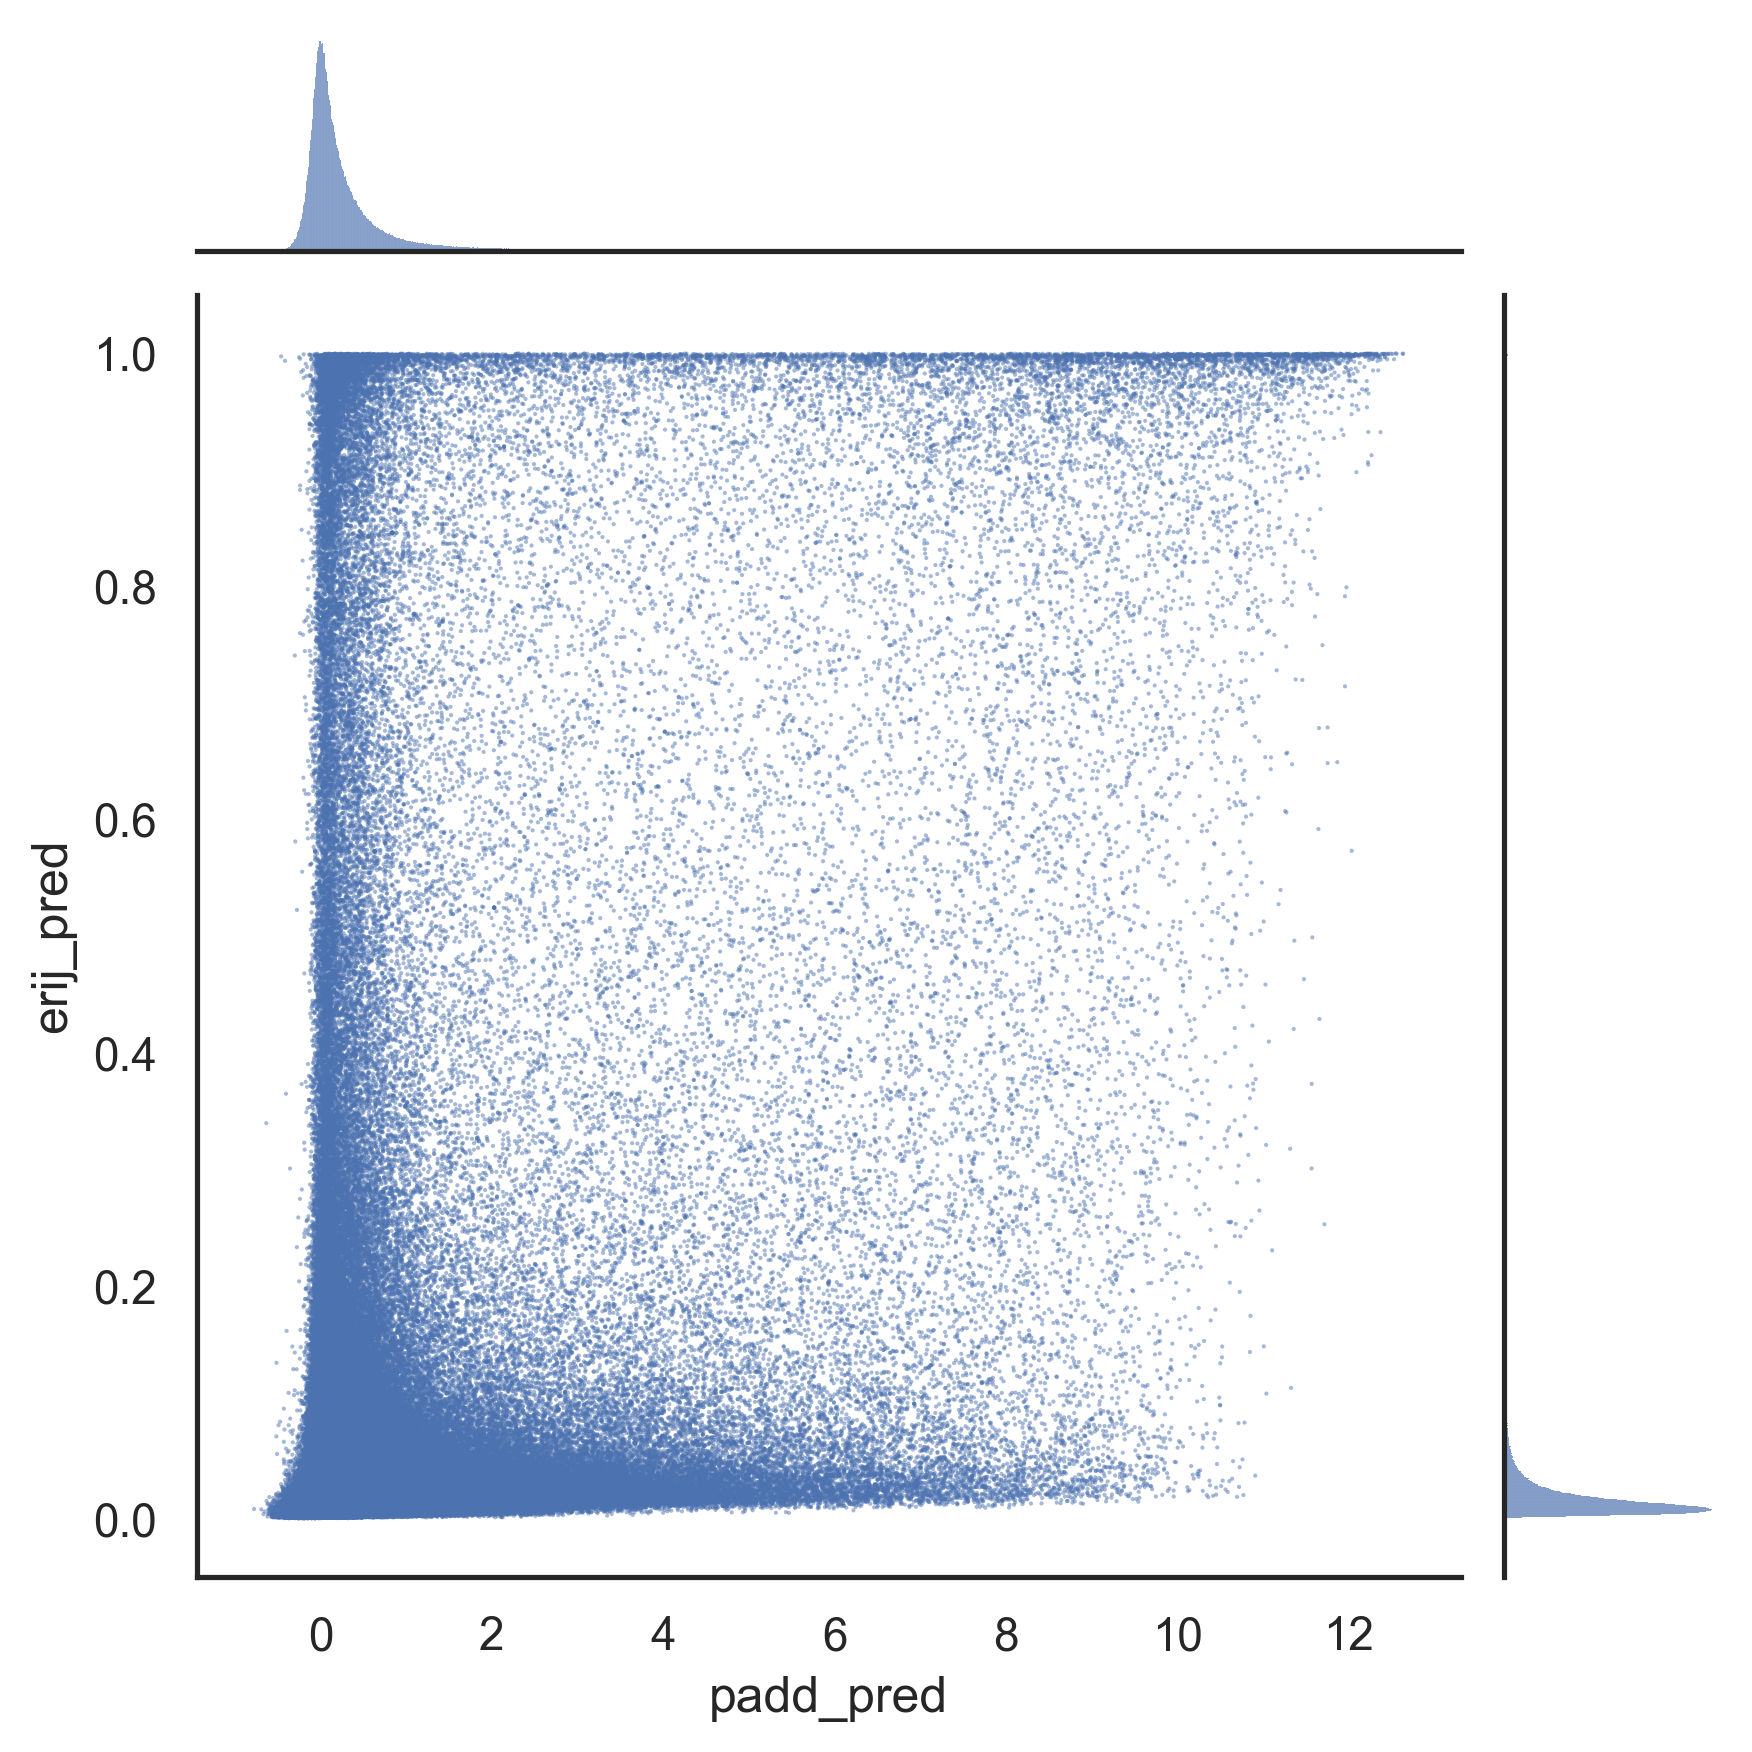

In [9]:
sns.jointplot(data=pred_output, x="padd_pred", y="erij_pred", kind="scatter", alpha=0.5, s=1, edgecolor='none')

<Axes: xlabel='erij_pred', ylabel='Count'>

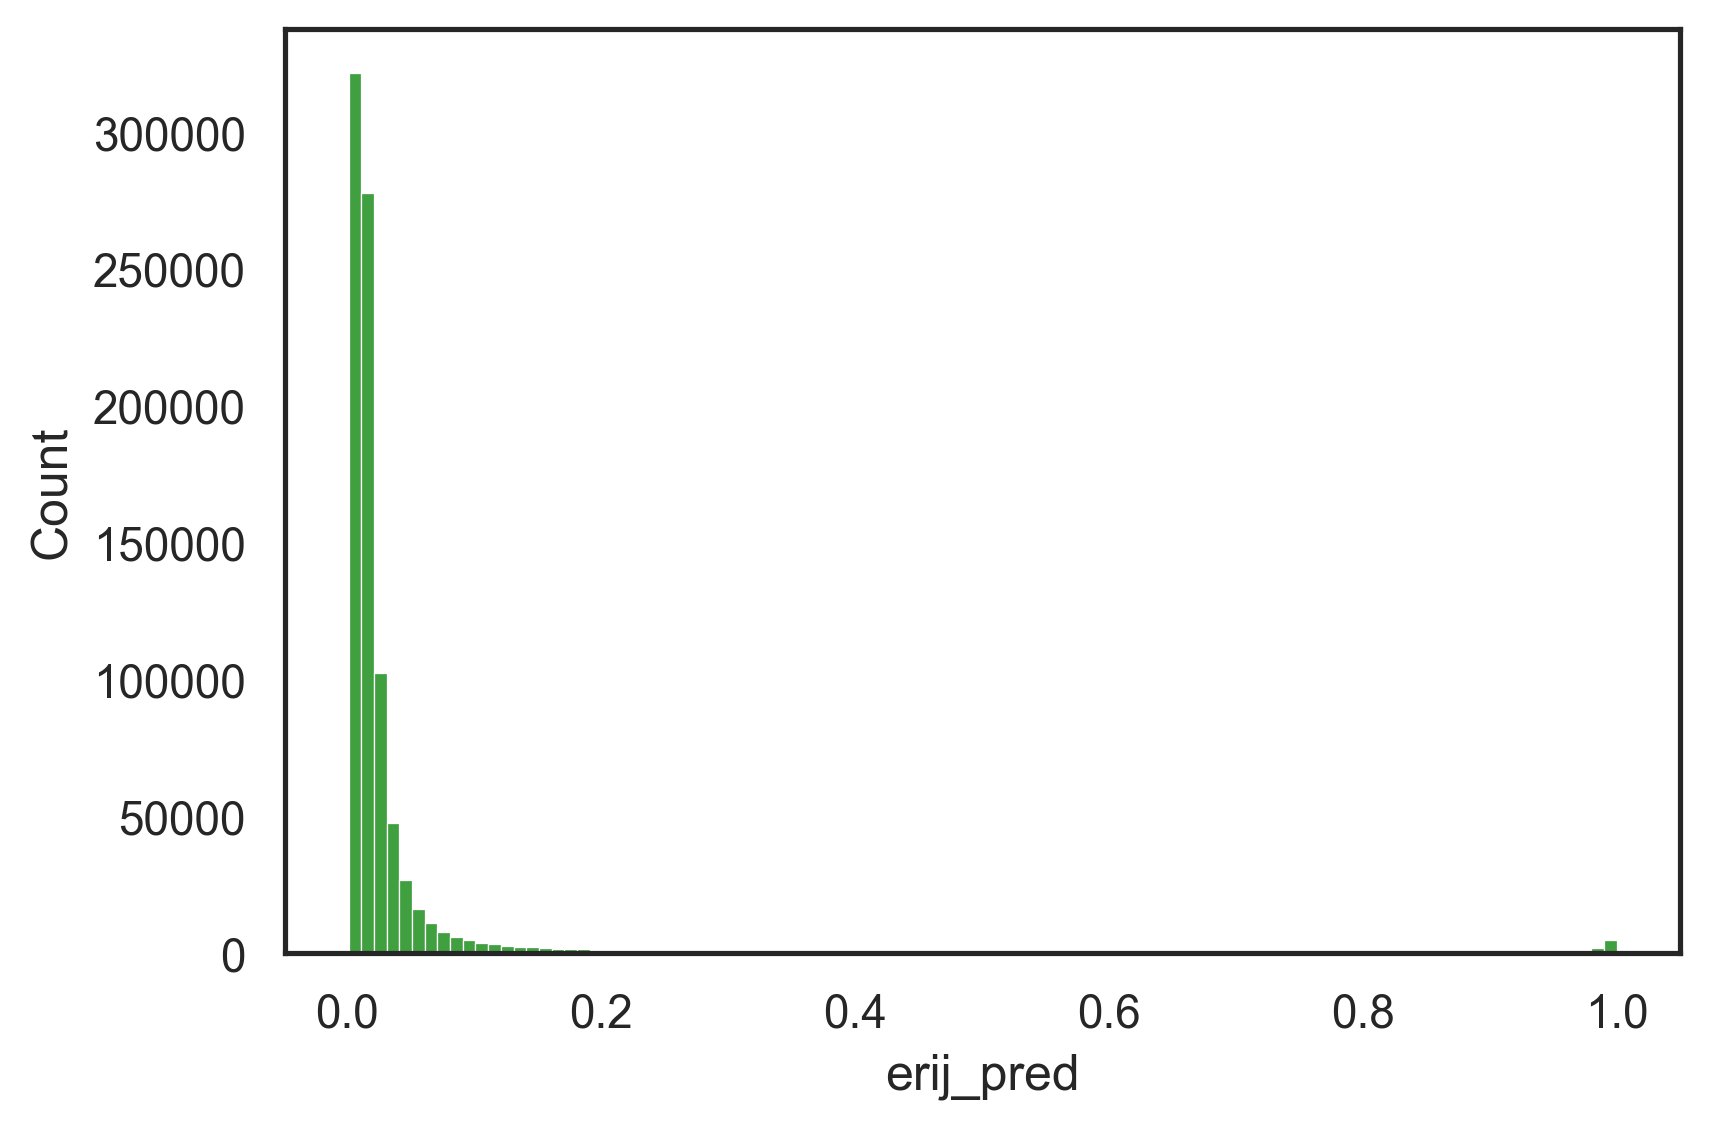

In [11]:
sns.histplot(pred_output["erij_pred"], bins = 100, color = 'green')

<Axes: xlabel='padd_pred', ylabel='Count'>

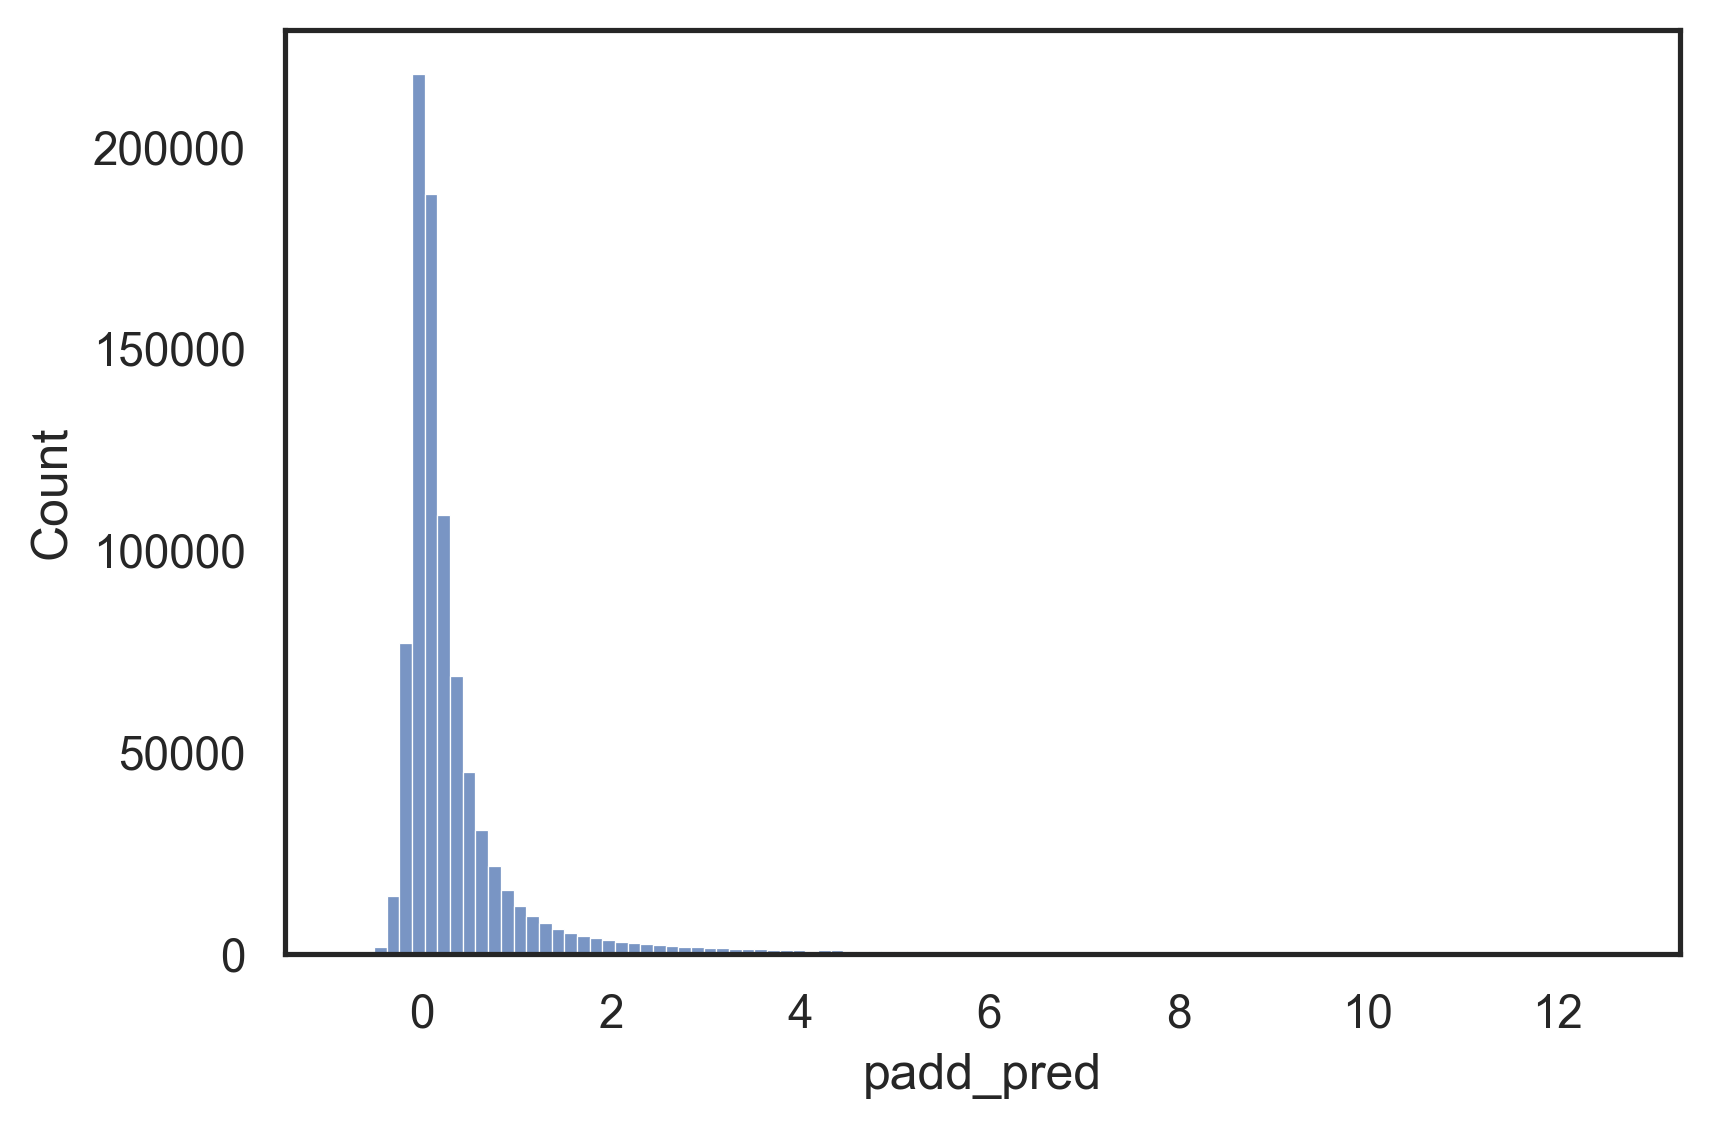

In [12]:
sns.histplot(pred_output["padd_pred"], bins = 100)

# for each position, get whether it overlaps AD or not

In [13]:
def add_overlap_status(df, domain_list, col_type, min_overlap = 32, col_name_suffix =  "_suffic_overlap"):
    # Keep rows of adhunter with annots
    # Calculate interval overlap
    # If there is overlap of at least 80% (so >= 32 residues) then there is sufficient overlap
    df_with_annots = pd.merge(df, domain_list, on = "uniprotID")
    df_with_annots["overlap_length"] =  df_with_annots[['End', 'annot_End']].min(axis=1) - df_with_annots[['Start', 'annot_Start']].max(axis=1)
    df_with_annots[col_type+ "_suffic_overlap"] = df_with_annots["overlap_length"] >= min_overlap
    #display(df_with_annots)
    
    # Keep first of each tile, such that if there is an overlappign tile it is saved
    df_with_annots = df_with_annots.sort_values(by = col_type+ "_suffic_overlap", ascending = False)
    df_with_annots = df_with_annots.drop_duplicates(subset = ["tile"], keep = "first")
    #display(df_with_annots)
    
    # Add info back to full tile table (includes TFs with no annotated ADs)
    #display(df)
    df = pd.merge(df, df_with_annots[["tile", col_type+ "_suffic_overlap"]], how = "left")
    df = df.fillna(False)
    return df

In [14]:
lambert_TFs = pd.read_csv("../data/LambertTFs.csv", index_col = 0)
lambert_TFs

,GeneName,ProteinSeq
0,sp|P23511|NFYA_HUMAN,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...
1,sp|Q96QS3|ARX_HUMAN,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...
2,sp|P31270|HXA11_HUMAN,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...
3,sp|P50221|MEOX1_HUMAN,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...
4,sp|P57073|SOX8_HUMAN,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...
...,...,...
1603,sp|P35227|PCGF2_HUMAN,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...
1604,sp|Q9BS34|ZN670_HUMAN,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...
1605,sp|P17098|ZNF8_HUMAN,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...
1606,sp|Q9UJW7|ZN229_HUMAN,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...


In [15]:
all_known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms.csv")
# Only keep ADs on Lambert TFs
lambert_TFs["uniprotID"] = lambert_TFs["GeneName"].str.split("|").str[1]
known_ADs = all_known_ADs[all_known_ADs["TileType"] == "TF"]
known_ADs = known_ADs[known_ADs["uniprotID"].isin(lambert_TFs["uniprotID"])]
known_ADs.head(3)

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN


In [16]:
# Adding uniprotID to adhunter to merge with known ADs
pred_output["uniprotID"] = pred_output["GeneName"].str.split("|").str[1]
pred_output = pred_output.rename(columns = {"StartPosition" : "Start", "EndPosition" : "End", "ProteinWindowSeq" : "tile"})
pred_output

,tile,GeneName,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge,padd_pred,erij_pred,uniprotID
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,39,0,1,0,2,6,1,1,1,3,5,-6,1.966898,0.024810,A0A087WUV0
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,40,0,1,0,1,6,1,1,1,3,5,-6,1.697406,0.015680,A0A087WUV0
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIR,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,41,0,1,0,1,6,1,1,2,3,4,-4,1.188476,0.016983,A0A087WUV0
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRD,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,42,0,1,0,1,6,1,1,2,4,4,-5,1.641205,0.019051,A0A087WUV0
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,43,0,1,0,2,6,1,1,2,4,3,-4,1.895335,0.027254,A0A087WUV0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888576,LLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1630,1669,0,1,1,1,5,2,5,8,2,2,9,-0.070133,0.012394,Q9Y6Y1
888577,LTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1631,1670,0,1,1,1,4,2,5,8,2,2,9,-0.047968,0.009591,Q9Y6Y1
888578,TKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1632,1671,0,1,1,1,3,3,5,8,2,2,9,0.057944,0.007870,Q9Y6Y1
888579,KKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1633,1672,0,1,1,1,3,3,5,8,2,2,9,-0.019041,0.005616,Q9Y6Y1


In [17]:
# Preparing known AD coords for merge
known_AD_coords = known_ADs[["uniprotID", "Start", "End"]]
known_AD_coords = known_AD_coords.rename(columns = {"Start" : "annot_Start", "End" : "annot_End"})
known_AD_coords

,uniprotID,annot_Start,annot_End
1,Q8IUX7,1088,1158
2,Q8WYP5,1445,1698
3,P35869,118,126
4,P35869,266,268
5,P35869,532,848
...,...,...,...
754,P98168,572,699
755,P98169,576,703
756,Q2QGD7,579,688
758,P05412,238,257


In [18]:
pred_output_overlap = add_overlap_status(pred_output, known_AD_coords, "AD")
pred_output_overlap

,tile,GeneName,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge,padd_pred,erij_pred,uniprotID,AD_suffic_overlap
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,39,0,1,0,2,6,1,1,1,3,5,-6,1.966898,0.024810,A0A087WUV0,False
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,40,0,1,0,1,6,1,1,1,3,5,-6,1.697406,0.015680,A0A087WUV0,False
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIR,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,41,0,1,0,1,6,1,1,2,3,4,-4,1.188476,0.016983,A0A087WUV0,False
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRD,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,42,0,1,0,1,6,1,1,2,4,4,-5,1.641205,0.019051,A0A087WUV0,False
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,43,0,1,0,2,6,1,1,2,4,3,-4,1.895335,0.027254,A0A087WUV0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888576,LLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1630,1669,0,1,1,1,5,2,5,8,2,2,9,-0.070133,0.012394,Q9Y6Y1,False
888577,LTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1631,1670,0,1,1,1,4,2,5,8,2,2,9,-0.047968,0.009591,Q9Y6Y1,False
888578,TKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1632,1671,0,1,1,1,3,3,5,8,2,2,9,0.057944,0.007870,Q9Y6Y1,False
888579,KKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1633,1672,0,1,1,1,3,3,5,8,2,2,9,-0.019041,0.005616,Q9Y6Y1,False


In [19]:
sum(pred_output_overlap["AD_suffic_overlap"])

58357

In [20]:
def process_overlaps(df):
    # Keep rows with at least one annotations
    return_df = df[(df["AD_suffic_overlap"]) | (df["RD_suffic_overlap"])]
    
    # Keep rows where AD and RD aren't both true
    return_df = return_df[~(return_df["AD_suffic_overlap"] & return_df["RD_suffic_overlap"])]

    return_df["active"] = (return_df["AD_suffic_overlap"]) & (~return_df["RD_suffic_overlap"])
    return return_df

In [21]:
known_RDs = pd.read_csv("../../SFARI/data/tycko_soto_delrosso_RD_coordinate_data_updated_12-2-24.csv", header = None)
known_RDs[1] = known_RDs[1].str.strip("[").str.strip("]").str.split(")")
known_RDs = known_RDs.explode(1)
known_RDs = known_RDs[known_RDs[1] != ""]
known_RDs["annot_Start"] = known_RDs[1].str.extract(r'\((\d+),').astype(int)
known_RDs["annot_End"] = known_RDs[1].str.extract(r', (\d+)$').astype(int)
known_RDs["uniprotID"] = known_RDs[0]
known_RDs = known_RDs[["uniprotID", "annot_Start", "annot_End"]]
known_RDs

,uniprotID,annot_Start,annot_End
0,A0A024R0Y4,11,90
1,A0A087X169,21,140
2,A0A0A0MRP6,11,140
2,A0A0A0MRP6,561,650
2,A0A0A0MRP6,881,960
...,...,...,...
1693,Q9Y6X8,263,446
1694,Q9Y6Y1,282,361
1694,Q9Y6Y1,472,721
1694,Q9Y6Y1,822,911


In [22]:
pred_output_overlap = add_overlap_status(pred_output_overlap, known_RDs, "RD")
pred_output_overlap

,tile,GeneName,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge,padd_pred,erij_pred,uniprotID,AD_suffic_overlap,RD_suffic_overlap
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,39,0,1,0,2,6,1,1,1,3,5,-6,1.966898,0.024810,A0A087WUV0,False,False
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,40,0,1,0,1,6,1,1,1,3,5,-6,1.697406,0.015680,A0A087WUV0,False,False
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIR,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,41,0,1,0,1,6,1,1,2,3,4,-4,1.188476,0.016983,A0A087WUV0,False,False
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRD,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,42,0,1,0,1,6,1,1,2,4,4,-5,1.641205,0.019051,A0A087WUV0,False,False
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,43,0,1,0,2,6,1,1,2,4,3,-4,1.895335,0.027254,A0A087WUV0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888576,LLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1630,1669,0,1,1,1,5,2,5,8,2,2,9,-0.070133,0.012394,Q9Y6Y1,False,False
888577,LTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1631,1670,0,1,1,1,4,2,5,8,2,2,9,-0.047968,0.009591,Q9Y6Y1,False,False
888578,TKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1632,1671,0,1,1,1,3,3,5,8,2,2,9,0.057944,0.007870,Q9Y6Y1,False,False
888579,KKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1633,1672,0,1,1,1,3,3,5,8,2,2,9,-0.019041,0.005616,Q9Y6Y1,False,False


In [23]:
sum(pred_output_overlap["RD_suffic_overlap"])

151819

In [24]:
pred_output_overlap[["AD_suffic_overlap", "RD_suffic_overlap"]].value_counts()

AD_suffic_overlap  RD_suffic_overlap
False              False                689495
                   True                 140729
True               False                 47267
                   True                  11090
Name: count, dtype: int64

In [25]:
known_DBDs = pd.read_csv("../../SFARI/output/lambert_TFs_10-21-24_with_DBD_coords.csv", index_col = 0)
known_DBDs = known_DBDs.dropna()
known_DBDs["DBD_coords_merged"] = known_DBDs["DBD_coords_merged"].str.split("], ")
known_DBDs = known_DBDs.explode("DBD_coords_merged")
known_DBDs["annot_Start"] = known_DBDs["DBD_coords_merged"].str.extract(r'\[(\d+),').astype(int)
known_DBDs["annot_End"] = known_DBDs["DBD_coords_merged"].str.extract(r', (\d+)').astype(int)
# known_RDs["uniprotID"] = known_RDs[0]
# known_RDs = known_RDs[["uniprotID", "annot_Start", "annot_End"]]
known_DBDs["uniprotID"] = known_DBDs["id"].str.split("|").str[1]
known_DBDs

,id,ProteinSeq,DBD_coords_merged,annot_Start,annot_End,uniprotID
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[[221, 243",221,243,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[249, 271",249,271,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[277, 299",277,299,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[305, 327",305,327,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[333, 355",333,355,A0A087WUV0
...,...,...,...,...,...,...
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[271, 317",271,317,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[442, 496",442,496,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[534, 584",534,584,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[633, 685]]",633,685,Q9Y6X8


In [26]:
pred_output_overlap = add_overlap_status(pred_output_overlap, known_DBDs, "DBD", min_overlap = 32)
pred_output_overlap

,tile,GeneName,Start,End,W,F,Y,M,L,Q,...,R,D,E,Charge,padd_pred,erij_pred,uniprotID,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,39,0,1,0,2,6,1,...,1,3,5,-6,1.966898,0.024810,A0A087WUV0,False,False,False
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,40,0,1,0,1,6,1,...,1,3,5,-6,1.697406,0.015680,A0A087WUV0,False,False,False
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIR,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,41,0,1,0,1,6,1,...,2,3,4,-4,1.188476,0.016983,A0A087WUV0,False,False,False
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRD,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,42,0,1,0,1,6,1,...,2,4,4,-5,1.641205,0.019051,A0A087WUV0,False,False,False
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDM,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,43,0,1,0,2,6,1,...,2,4,3,-4,1.895335,0.027254,A0A087WUV0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888576,LLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1630,1669,0,1,1,1,5,2,...,8,2,2,9,-0.070133,0.012394,Q9Y6Y1,False,False,False
888577,LTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1631,1670,0,1,1,1,4,2,...,8,2,2,9,-0.047968,0.009591,Q9Y6Y1,False,False,False
888578,TKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1632,1671,0,1,1,1,3,3,...,8,2,2,9,0.057944,0.007870,Q9Y6Y1,False,False,False
888579,KKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1633,1672,0,1,1,1,3,3,...,8,2,2,9,-0.019041,0.005616,Q9Y6Y1,False,False,False


In [27]:
sum(pred_output_overlap["DBD_suffic_overlap"])

93108

In [28]:
def process_overlaps_with_dbd(df):
    # Keep rows with at least one annotations
    return_df = df[(df["AD_suffic_overlap"]) | (df["RD_suffic_overlap"]) | (df["DBD_suffic_overlap"])]
    
    # Keep rows where only one annot type
    return_df["annot_count"] = return_df["AD_suffic_overlap"].astype(int) + return_df["RD_suffic_overlap"].astype(int) + return_df["DBD_suffic_overlap"].astype(int)
    return_df = return_df[return_df["annot_count"] == 1]

    return_df["active"] = (return_df["AD_suffic_overlap"]) & (~return_df["RD_suffic_overlap"]) & (~return_df["DBD_suffic_overlap"])
    return return_df

def print_overlap_counts(pred_overlap, pred_ad_rd, pred_ad_rd_dbd):
    print("Total predictions: " + str(len(pred_overlap)))
    print("AD or RD overlapping: " + str(len(pred_ad_rd)))
    print("AD or RD or DBD overlapping: " + str(len(pred_ad_rd_dbd)))

In [29]:
processed_output = process_overlaps_with_dbd(pred_output_overlap)
processed_output

,tile,GeneName,Start,End,W,F,Y,M,L,Q,...,E,Charge,padd_pred,erij_pred,uniprotID,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap,annot_count,active
591,KSQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEV,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,107,146,0,1,2,0,5,1,...,2,2,0.146055,0.014963,A0AVK6,False,False,True,1,False
592,SQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVA,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,108,147,0,1,2,0,5,1,...,2,1,0.150096,0.016322,A0AVK6,False,False,True,1,False
593,QPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAE,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,109,148,0,1,2,0,5,1,...,3,0,0.141041,0.017500,A0AVK6,False,False,True,1,False
594,PSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEE,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,110,149,0,1,2,0,5,0,...,4,-1,0.006168,0.017917,A0AVK6,False,False,True,1,False
595,SRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEEL,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,111,150,0,1,2,0,6,0,...,4,-1,0.331292,0.022141,A0AVK6,False,False,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887961,NGGSQAQCASGTGALGSCFESRVVVVCEKMMSRACWAKS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1015,1054,1,1,0,2,1,2,...,2,2,0.100342,0.007418,Q9Y6Y1,False,True,False,1,False
887962,GGSQAQCASGTGALGSCFESRVVVVCEKMMSRACWAKSK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1016,1055,1,1,0,2,1,2,...,2,3,0.009807,0.007907,Q9Y6Y1,False,True,False,1,False
887963,GSQAQCASGTGALGSCFESRVVVVCEKMMSRACWAKSKH,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1017,1056,1,1,0,2,1,2,...,2,3,0.024166,0.007527,Q9Y6Y1,False,True,False,1,False
887964,SQAQCASGTGALGSCFESRVVVVCEKMMSRACWAKSKHL,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1018,1057,1,1,0,2,2,2,...,2,3,0.110499,0.007116,Q9Y6Y1,False,True,False,1,False


In [30]:
# Helper functions
def formatting():
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine()

def plot_prc(df, pred_name, color="b", active_col_name="active"):
    precision, recall, thresholds = precision_recall_curve(df[active_col_name], df[pred_name])
    plt.plot(recall, precision, color=color)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    formatting()
    return auc(recall, precision)

def plot_roc(df, pred_name, color="b", first=True, text=True, active_col_name="active"):
    fpr, tpr, thresholds = roc_curve(df[active_col_name], df[pred_name])
    plt.plot(fpr, tpr, color=color)
    plt.xlabel("FPR")
    plt.ylabel("TPR")

    # Calculate AUROC and display it on the plot
    auroc = roc_auc_score(df[active_col_name], df[pred_name])
    if text:
        y = 0.15 if first else 0.05
        plt.text(x=0.95, y=y, s=f"AUROC = {auroc:.2f}", fontsize='small', va="bottom", ha="right", color=color)

    # Find the best threshold (closest to the top-left corner)
    best_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_idx]
    print(f"Best threshold for {pred_name}: {best_threshold:.4f}")

    formatting()
    return auroc

def add_custom_legend(color_dict, ax, bbox_to_anchor=(1, 1)):
    custom_lines = [Line2D([0], [0], markersize=2, color=c, lw=4) for c in color_dict.values()]
    ax.legend(custom_lines, color_dict.keys(), bbox_to_anchor=bbox_to_anchor, frameon=False, fontsize='x-small', handlelength=0.5)

def plot_prc_roc(df, pred_name, active_col_name='active'):
    activator_color = sns.color_palette('colorblind')[1]
    all_color = sns.color_palette('colorblind')[0]
    
    # Create two subplots sharing the y-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))
    activator_TF = df[df["uniprotID"].isin(known_ADs["uniprotID"])]

    # Plot Precision-Recall on the first subplot
    plt.sca(ax1)  # Switch to ax1
    plt.plot([0, 1], [0, 1], 'k--', color="gray", lw=1)
    plot_roc(df, pred_name, all_color, first=True, active_col_name=active_col_name)
    plot_roc(activator_TF, pred_name, activator_color, first=False, active_col_name=active_col_name)

    # Plot ROC curve on the second subplot
    plt.sca(ax2)  # Switch to ax2
    all_TF_random_luck = sum(df[active_col_name]) / len(df)
    plt.axhline(all_TF_random_luck, linestyle='--', color=all_color, lw=1)

    activ_TF_random_luck = sum(activator_TF[active_col_name]) / len(activator_TF)
    plt.axhline(activ_TF_random_luck, linestyle='--', color=activator_color, lw=1)

    plot_prc(df, pred_name, all_color, active_col_name=active_col_name)
    plot_prc(activator_TF, pred_name, activator_color, active_col_name=active_col_name)

    add_custom_legend({"All TFs": all_color, "Activator TFs": activator_color}, ax=ax2)
    plt.subplots_adjust(wspace=0.2, hspace=0)


Best threshold for padd_pred: 0.3676
Best threshold for padd_pred: 0.4168


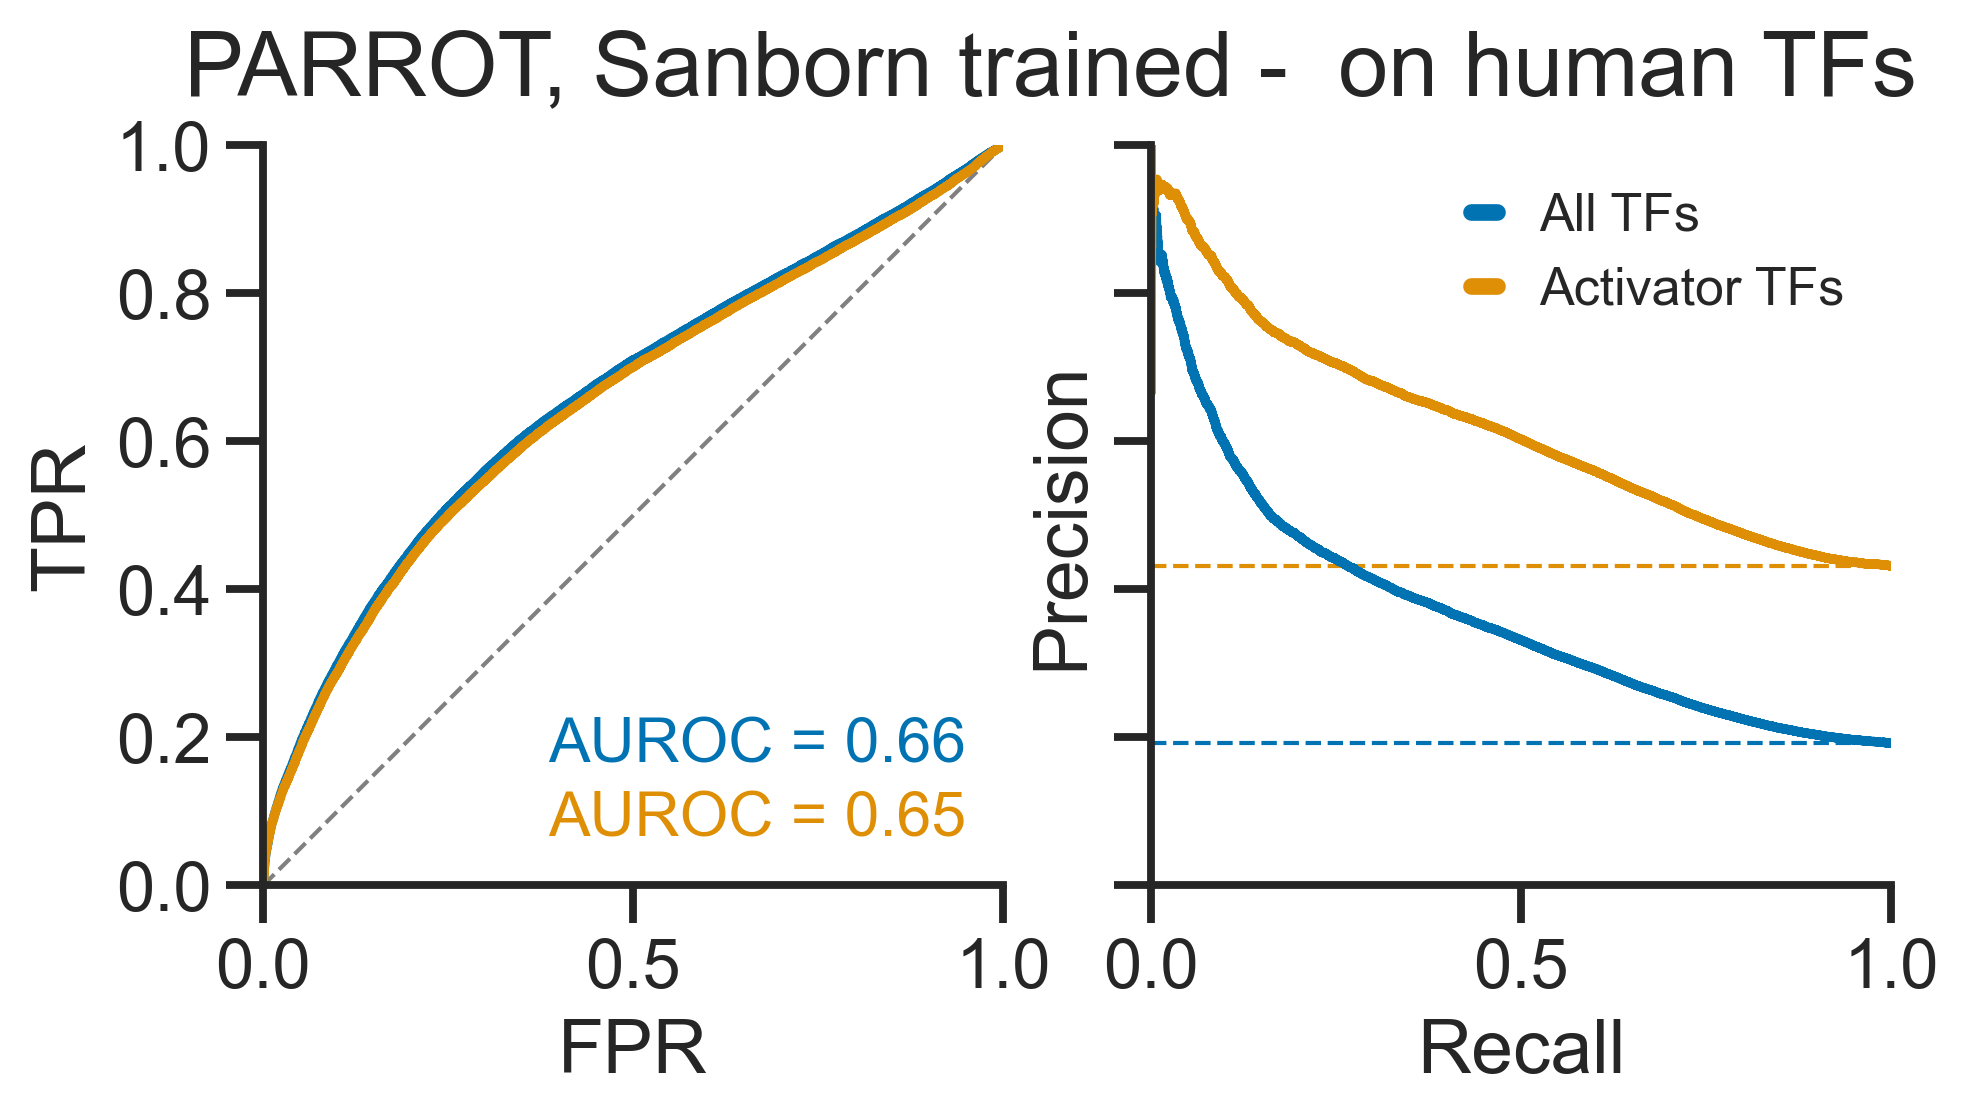

In [37]:
sns.set_style('ticks')
sns.set_context('talk')
plot_prc_roc(processed_output, "padd_pred")
plt.suptitle("PARROT, Sanborn trained -  on human TFs", y = 0.9)
plt.show()

Best threshold for erij_pred: 0.0917
Best threshold for erij_pred: 0.1086


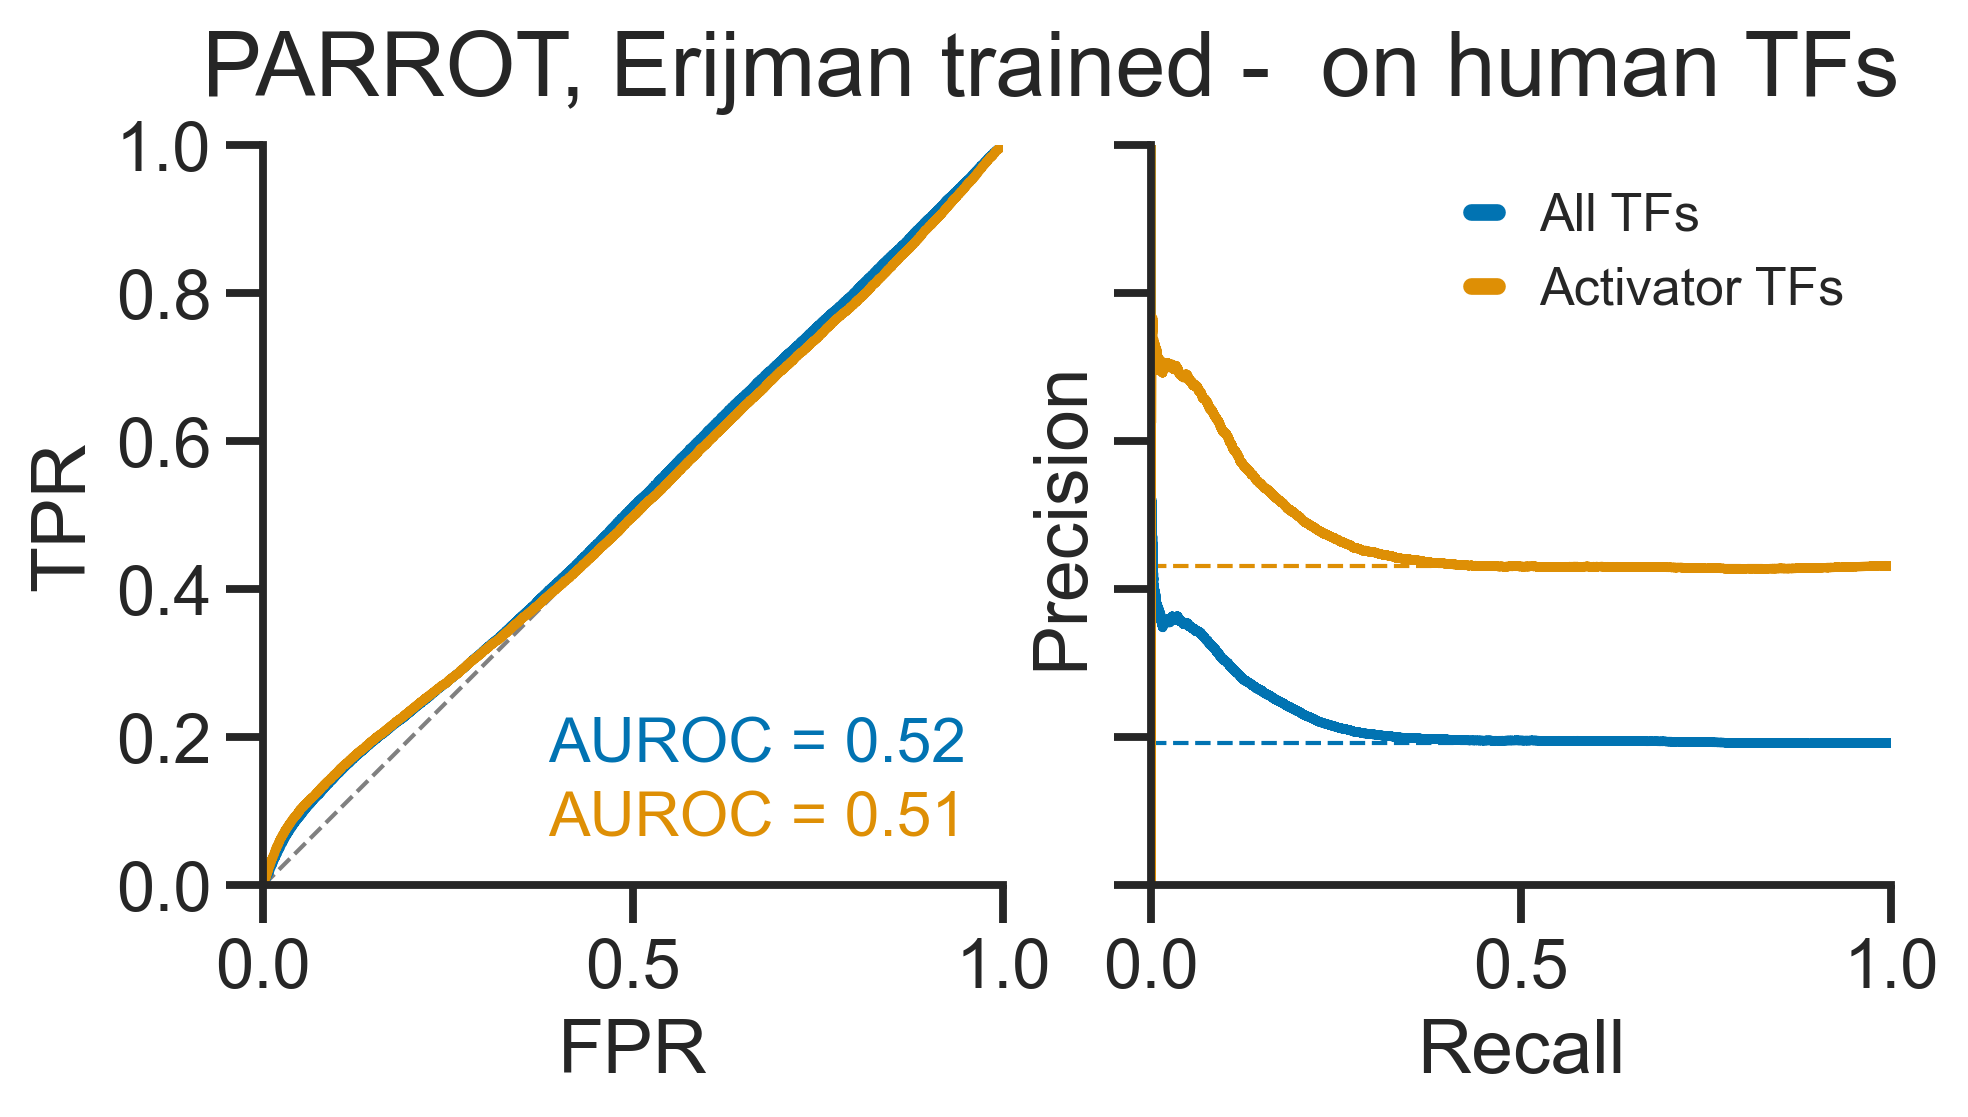

In [39]:
sns.set_style('ticks')
sns.set_context('talk')
plot_prc_roc(processed_output, "erij_pred")
plt.suptitle("PARROT, Erijman trained -  on human TFs", y = 0.9)
plt.show()

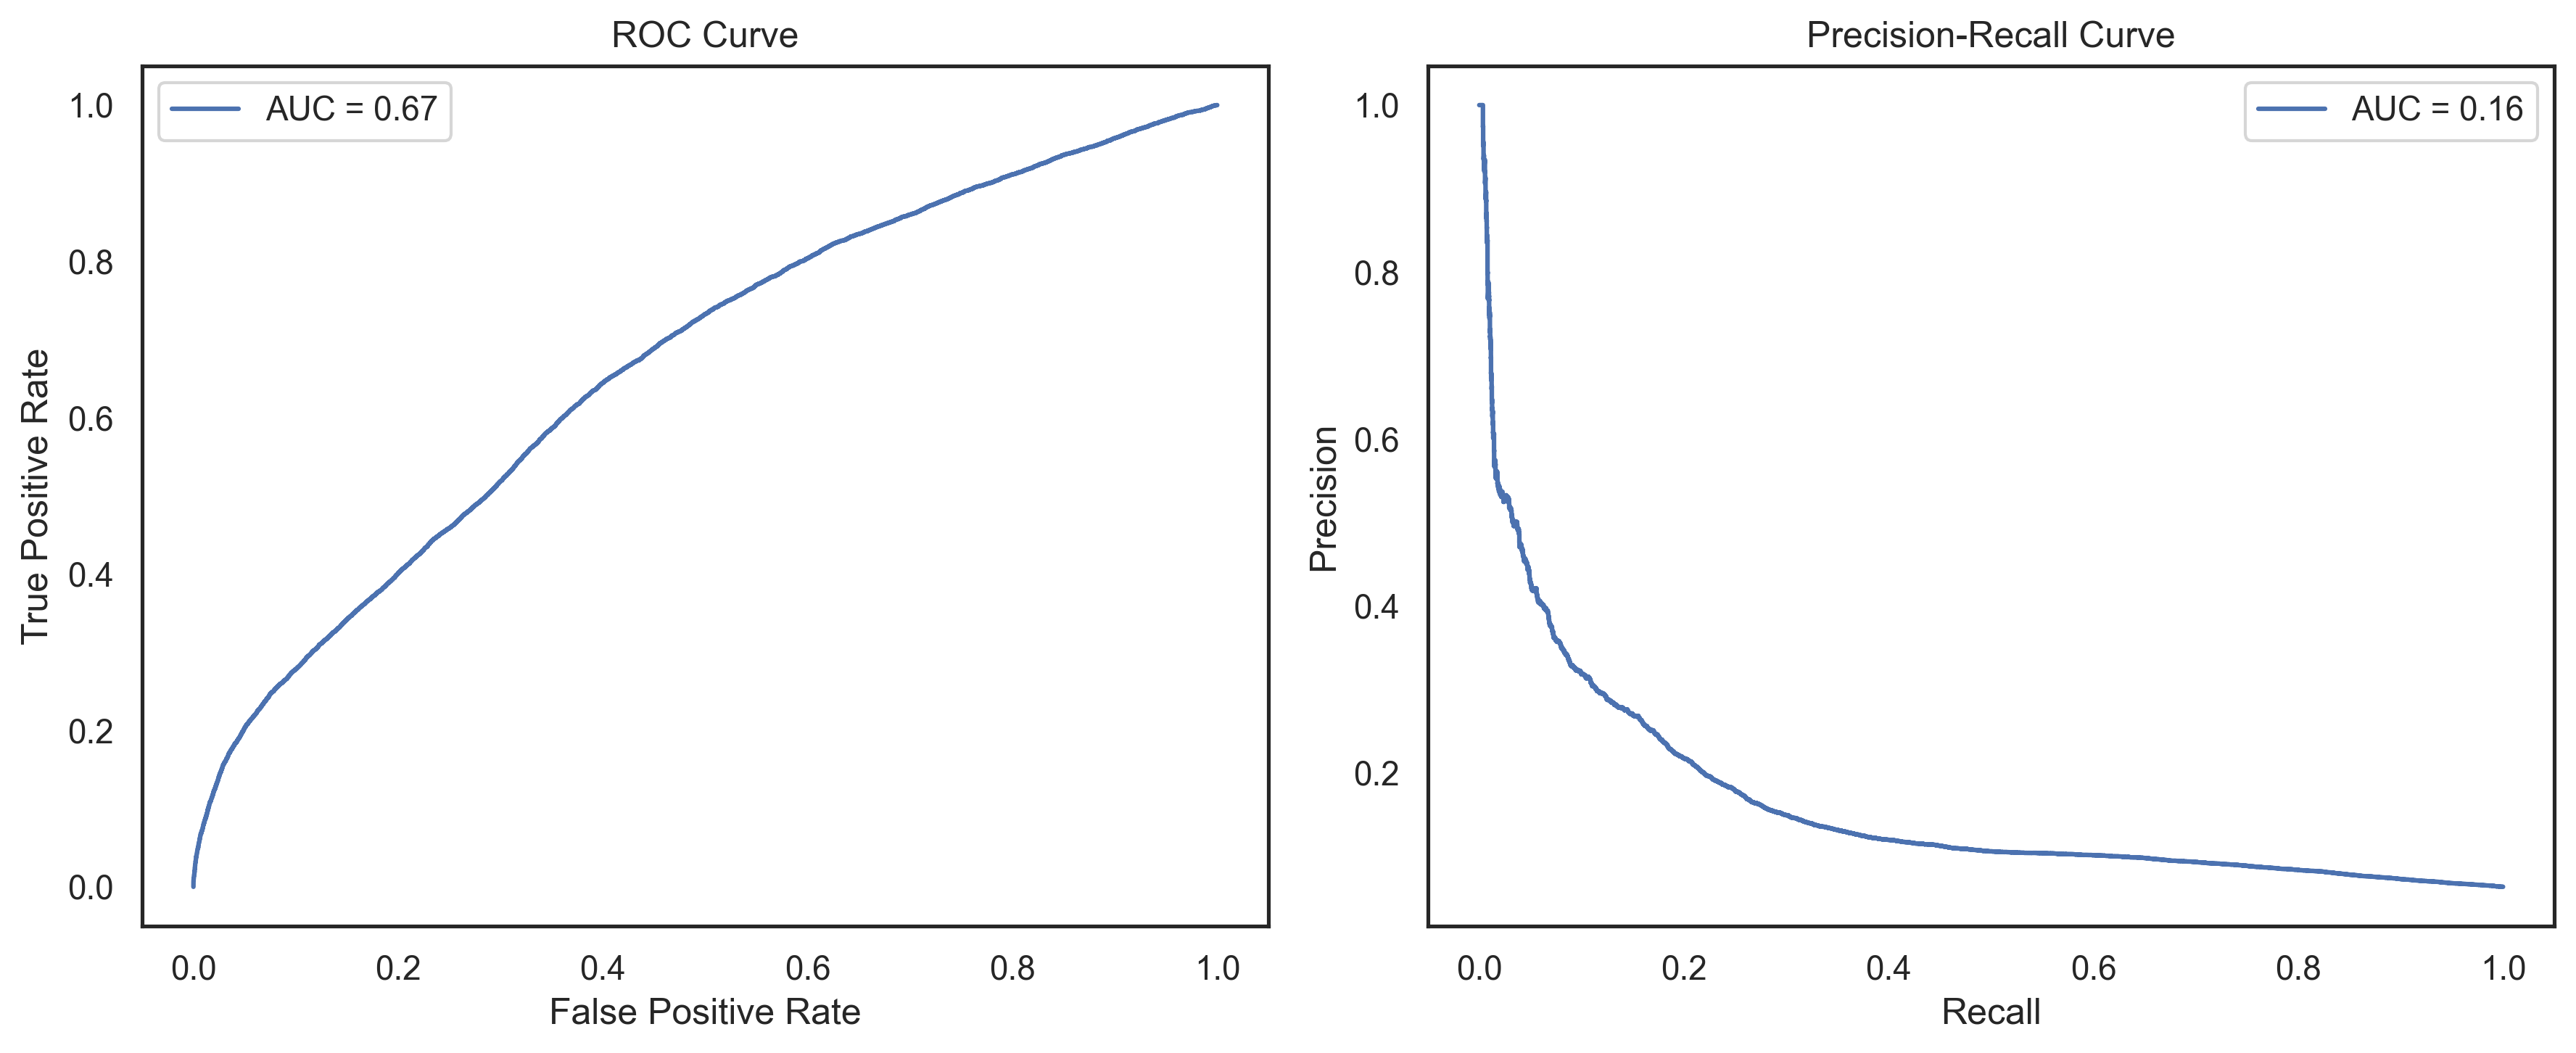

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(preds_with_truth["AD"], preds_with_truth["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
#plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
#plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Get thresholds from the precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])

# Calculate F1 score for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
best_f1 = f1_scores[best_index]

print(f"Best Threshold (by max F1): {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {best_f1:.4f}")

Best Threshold (by max F1): 0.2837
F1 Score at Best Threshold: 0.2103


# compare to input

In [10]:
human_yeast_preds_input = pd.read_csv("../output/human_yeast_aggreg_preds.tsv",     
            header=None
)
human_yeast_preds_input["uniprotID"] = human_yeast_preds_input[0].str.split(r"\t").str[0]
human_yeast_preds_input["values"] = human_yeast_preds_input[0].str.split(r"\t").str[2:]
human_yeast_preds_input["values"] = human_yeast_preds_input["values"].apply(lambda arr: [float(val) for val in arr if val != ""])
human_yeast_preds_input

,0,uniprotID,values
0,P23511\tMEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTE...,P23511,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Q96QS3\tMSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSP...,Q96QS3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,P31270\tMDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTP...,P31270,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
3,P50221\tMDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHY...,P50221,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,P57073\tMLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAG...,P57073,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
1850,Q707Y3\tMPSRTPTDIWRCQRLILAARKGETTCQALHEQSIEISS...,Q707Y3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1851,Q707Y6\tMQFTILNEPSLDSQRREGDLASENYVFGDIRKEGVRIL...,Q707Y6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1852,Q708A1\tMNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVIN...,Q708A1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1853,Q9HG12\tMCDNDMADIQSKLSSFCEEIRALALKEGYNLEGDKSPS...,Q9HG12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
human_yeast_preds_input["positions"] = [np.arange(1, len(v) + 1) for v in human_yeast_preds_input["values"]]
input_positions = human_yeast_preds_input.drop(columns = [0]).explode(["values", "positions"])
input_positions

,uniprotID,values,positions
0,P23511,0.0,1
0,P23511,0.0,2
0,P23511,0.0,3
0,P23511,0.0,4
0,P23511,0.0,5
...,...,...,...
1854,Q9HG13,0.0,253
1854,Q9HG13,0.0,254
1854,Q9HG13,0.0,255
1854,Q9HG13,0.0,256


In [12]:
input_with_truth = pd.merge(input_positions, known_ADs, how = 'left')
input_with_truth["AD"] = input_with_truth["AD"].fillna(0)
input_with_truth

,uniprotID,values,positions,AD
0,P23511,0.0,1,1.0
1,P23511,0.0,2,1.0
2,P23511,0.0,3,1.0
3,P23511,0.0,4,1.0
4,P23511,0.0,5,1.0
...,...,...,...,...
1090986,Q9HG13,0.0,253,0.0
1090987,Q9HG13,0.0,254,0.0
1090988,Q9HG13,0.0,255,0.0
1090989,Q9HG13,0.0,256,0.0


In [13]:
TF_lim_input = input_with_truth[input_with_truth["uniprotID"].isin(preds_with_truth["uniprotID"])]
TF_lim_input

,uniprotID,values,positions,AD
1222,P50221,0.0,1,0.0
1223,P50221,0.0,2,0.0
1224,P50221,0.0,3,0.0
1225,P50221,0.0,4,0.0
1226,P50221,0.0,5,0.0
...,...,...,...,...
1090198,Q707Y3,0.0,172,0.0
1090199,Q707Y3,0.0,173,0.0
1090200,Q707Y3,0.0,174,0.0
1090201,Q707Y3,0.0,175,0.0


In [22]:
# Get thresholds from the precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])

# Calculate F1 score for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
best_f1 = f1_scores[best_index]

print(f"Best Threshold (by max F1): {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {best_f1:.4f}")

Best Threshold (by max F1): 0.6000
F1 Score at Best Threshold: 0.2116


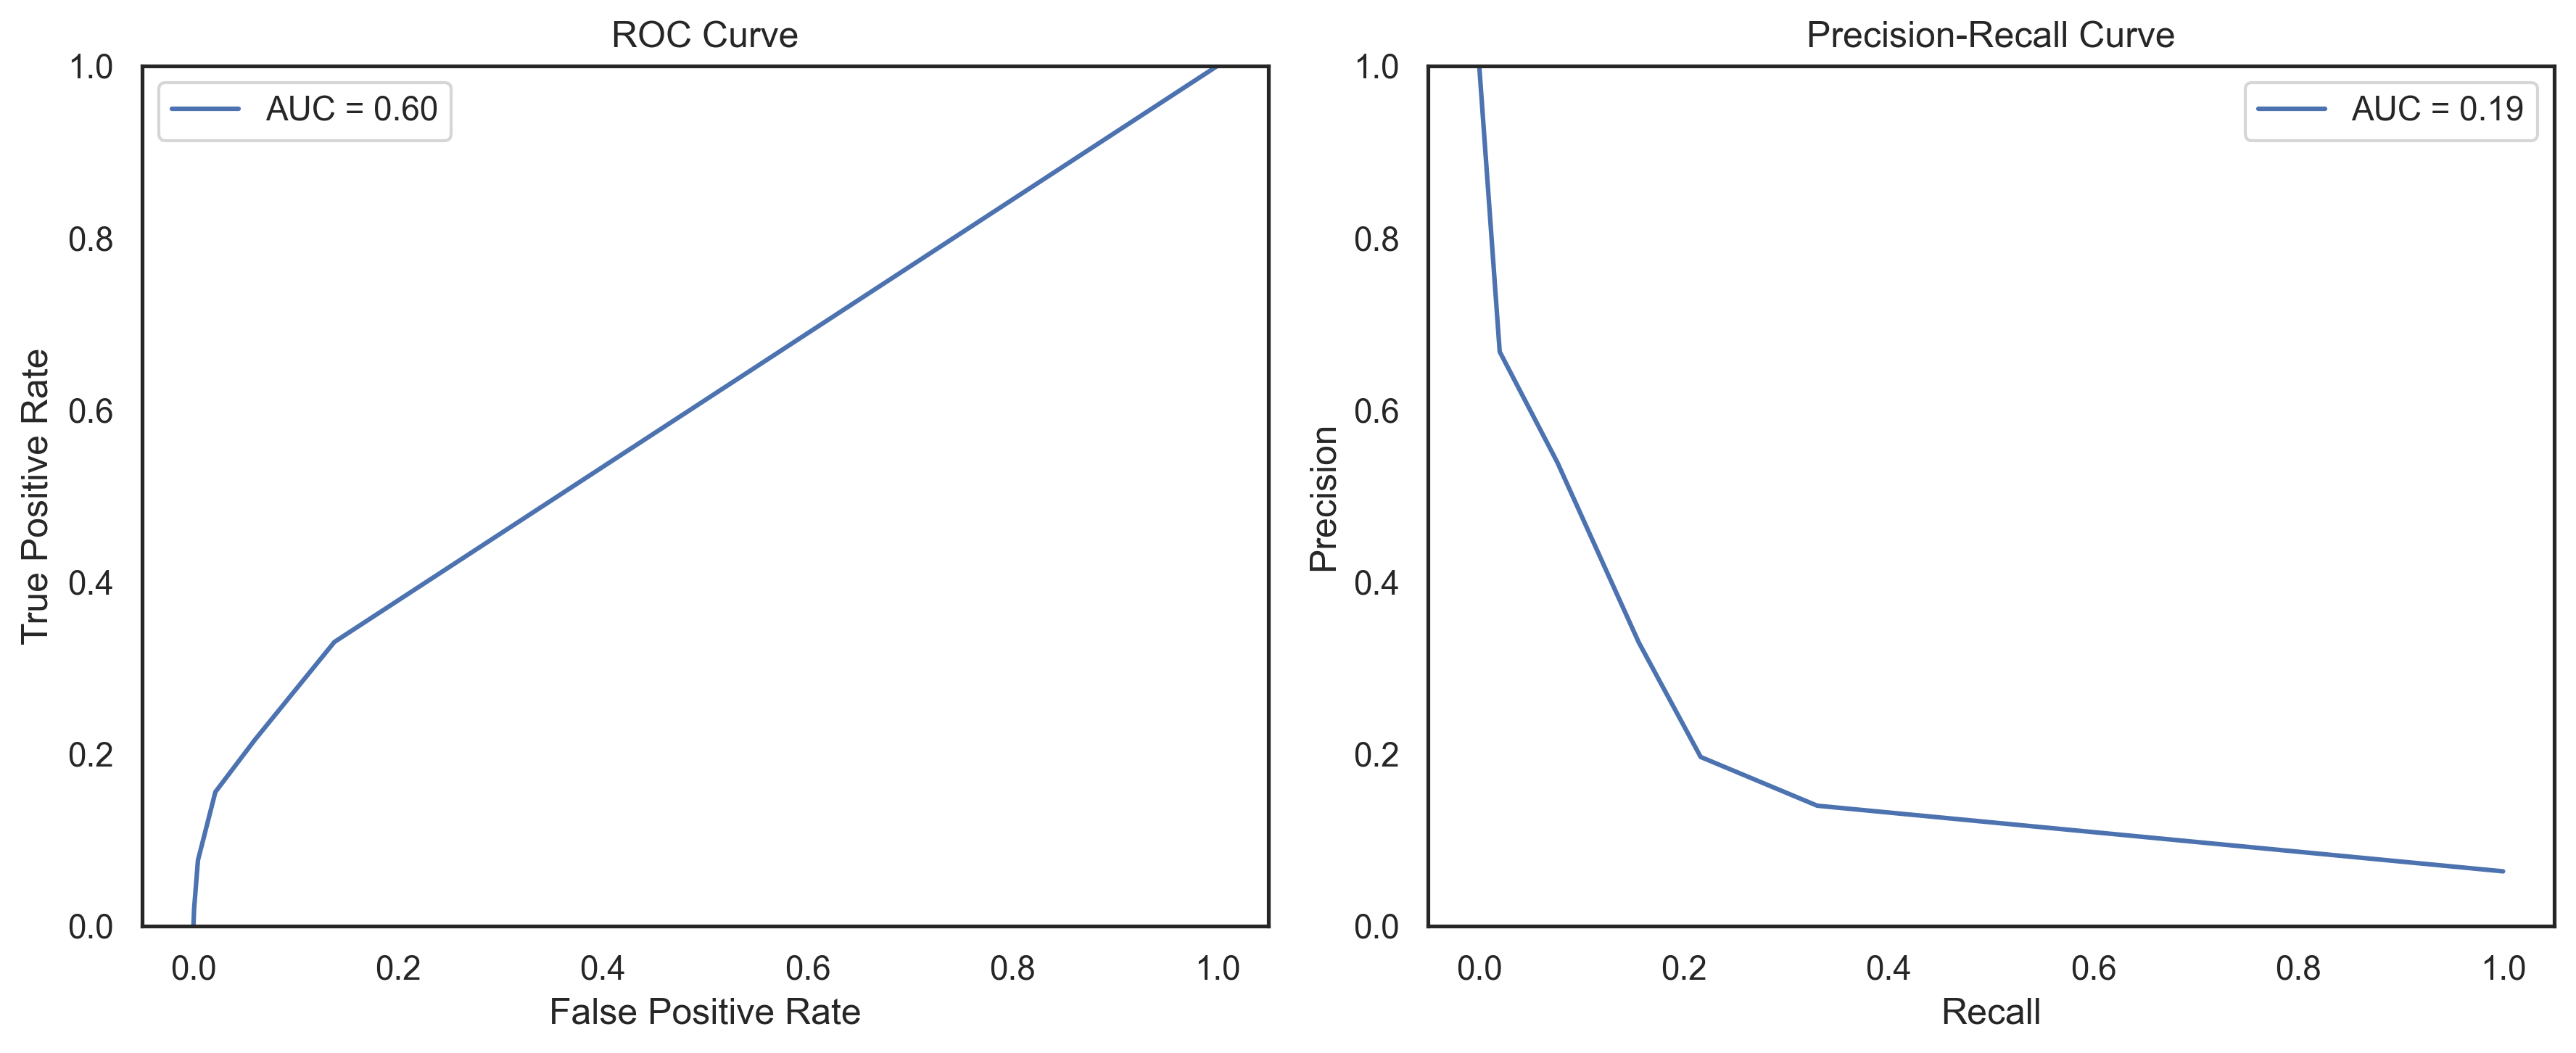

In [14]:
# ROC Curve
fpr, tpr, _ = roc_curve(TF_lim_input["AD"], TF_lim_input["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


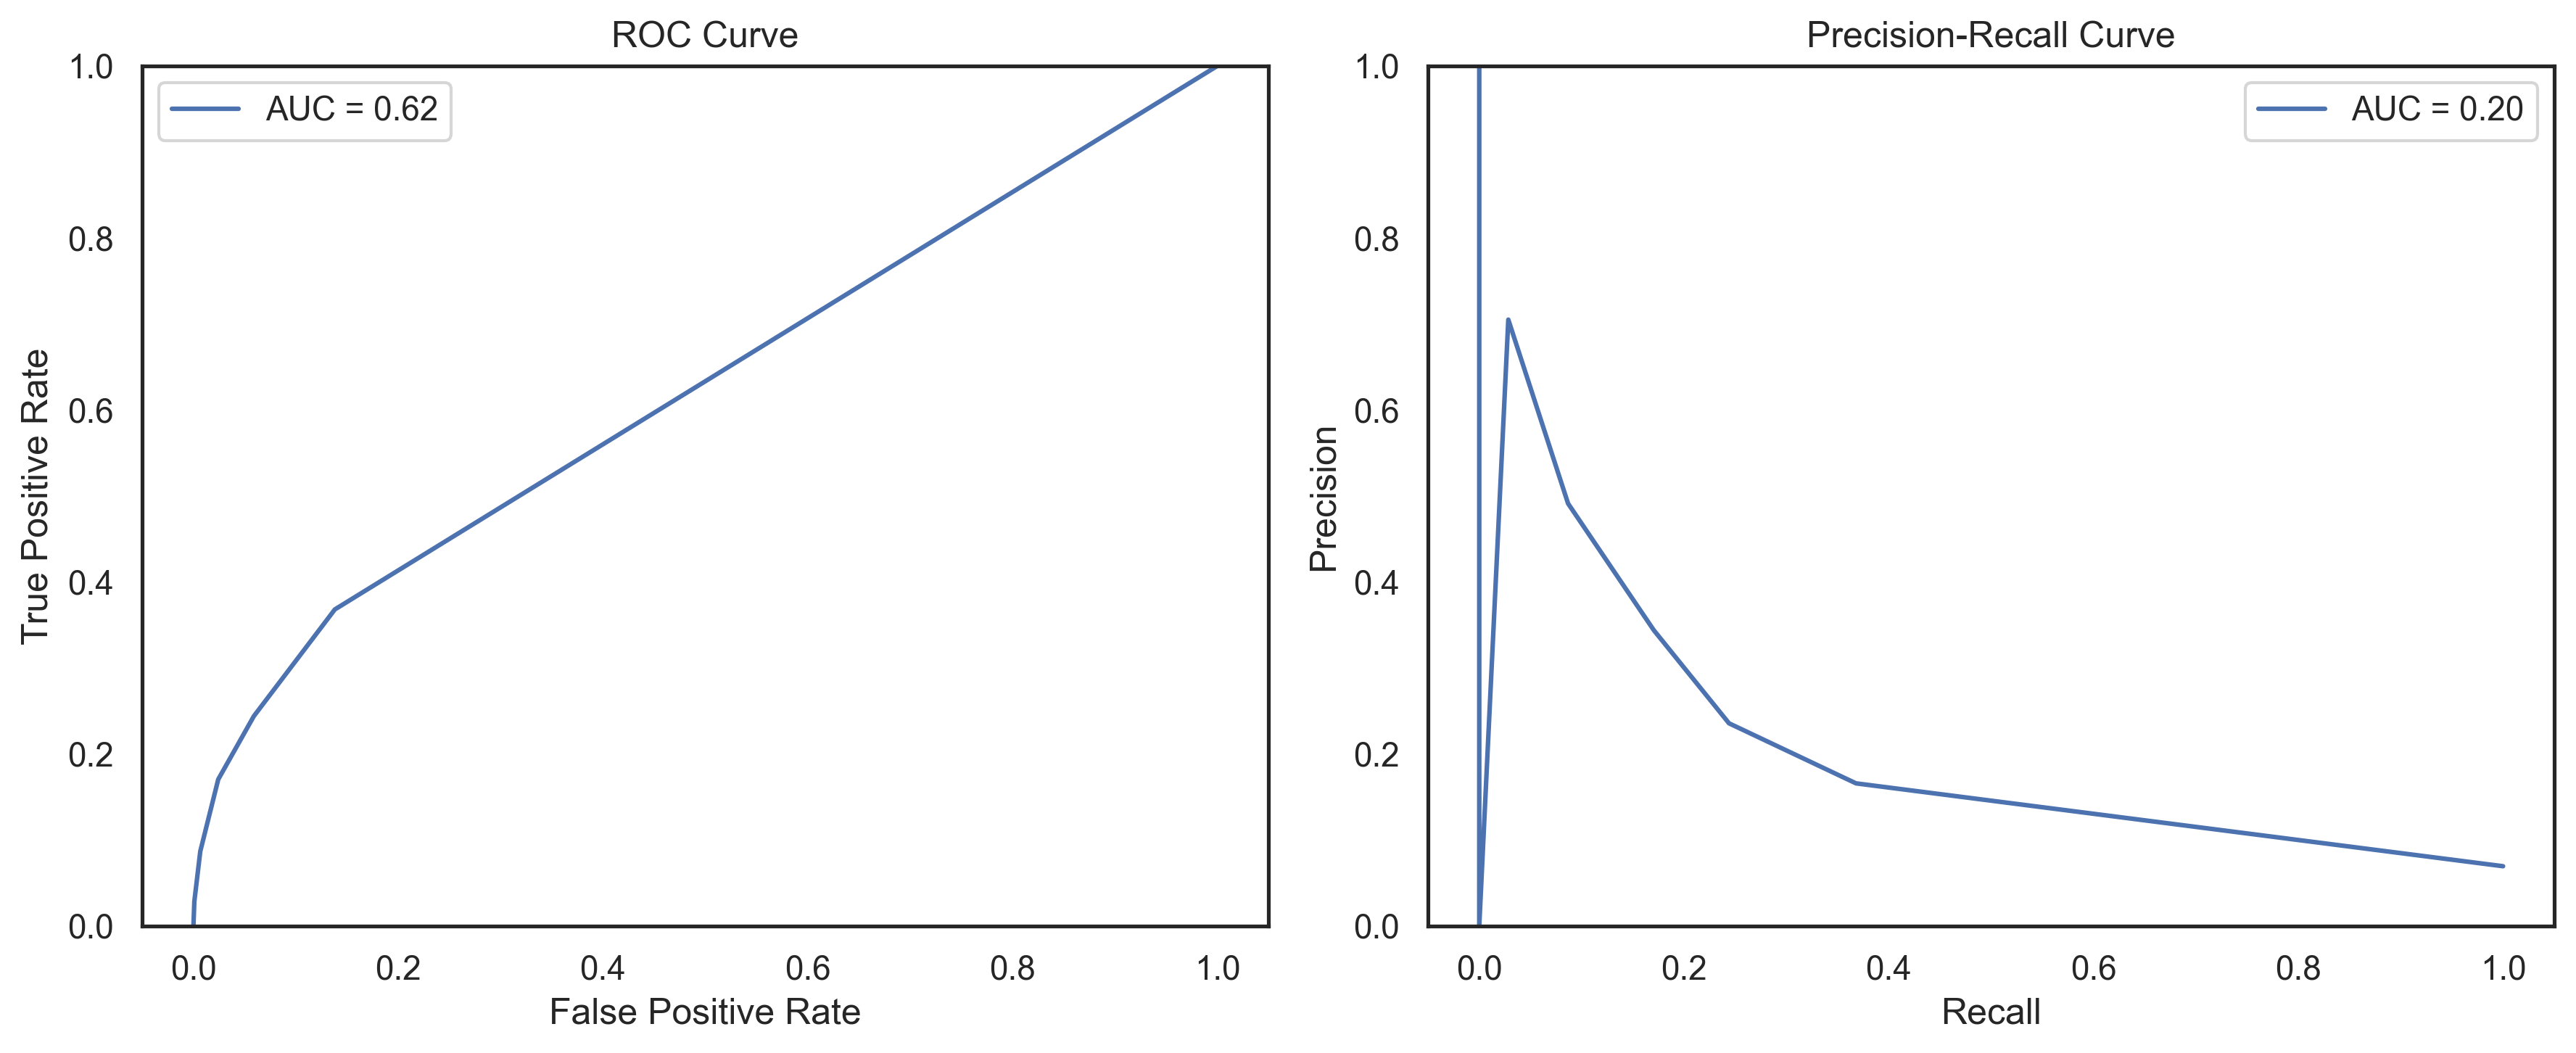

In [15]:
# ROC Curve
fpr, tpr, _ = roc_curve(input_with_truth["AD"], input_with_truth["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(input_with_truth["AD"], input_with_truth["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.1, 'PARROT Human + Yeast TF-Trained Consensus:\nTest Human TFs')

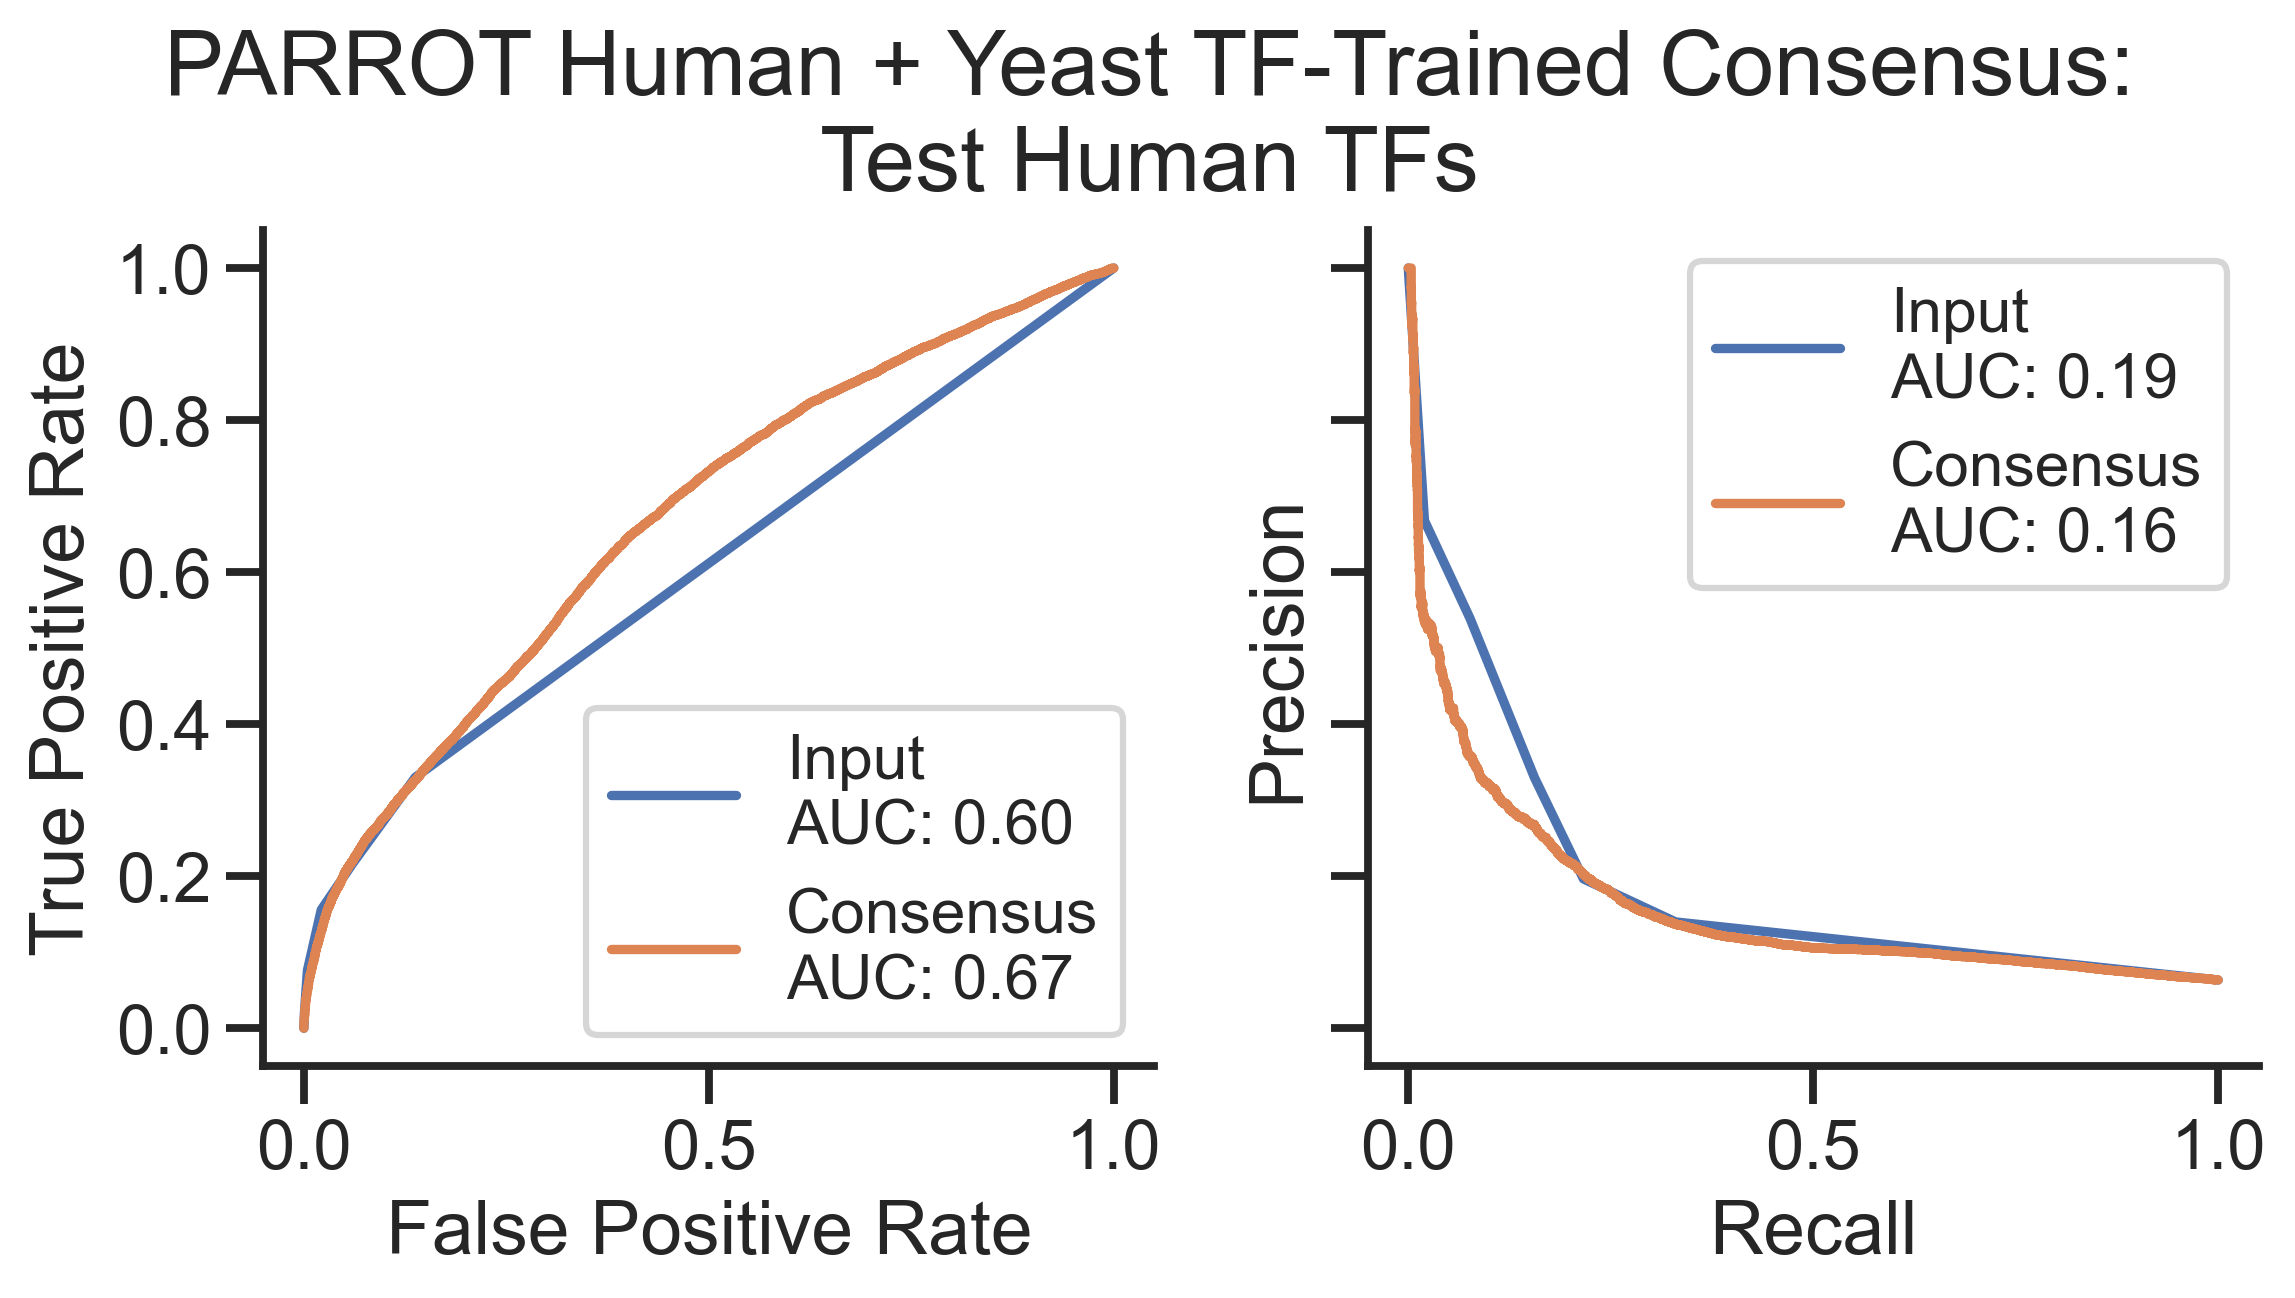

In [23]:
sns.set_context('talk')
sns.set_style('ticks')

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

## ROC

# Input
fpr, tpr, _ = roc_curve(TF_lim_input["AD"], TF_lim_input["values"])
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label=f"Input\nAUC: {roc_auc:.2f}")

# Preds
fpr, tpr, _ = roc_curve(preds_with_truth["AD"], preds_with_truth["values"])
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label=f"Consensus\nAUC: {roc_auc:.2f}")



axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(fontsize = 'small')

## PRC

# Input
precision, recall, _ = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])
prc_auc = auc(recall, precision)

axs[1].plot(recall, precision, label=f"Input\nAUC: {prc_auc:.2f}")

# Preds
precision, recall, _ = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])
prc_auc = auc(recall, precision)

axs[1].plot(recall, precision, label=f"Consensus\nAUC: {prc_auc:.2f}")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")


axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend(fontsize = 'small')

sns.despine()
plt.tight_layout()

plt.suptitle("PARROT Human + Yeast TF-Trained Consensus:\nTest Human TFs", y = 1.1)